In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynumdiff
import cvxpy
from scipy.signal import find_peaks
from itertools import cycle
import multiprocessing
import time
import warnings
import os


2024-12-05 17:45:46,383 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [2]:
from braid_analysis import braid_filemanager
from braid_analysis import braid_slicing
from braid_analysis import braid_analysis_plots
from braid_analysis import flymath

2024-12-05 17:45:46,734 [INFO] topicmanager initialized
2024-12-05 17:45:46,746 [WARNING] Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [3]:
print("setting threads variable")
os.environ['NUMEXPR_MAX_THREADS'] = '8'


setting threads variable


In [4]:
def median_angle(angle):
    return np.arctan2(np.median(np.sin(angle)), np.median(np.cos(angle)))

def get_score_amp(args):
    traj, t, delta_frames, time_key, dt = args
    sub_slice = traj[traj[time_key].between(t - delta_frames*dt, 
                                       t + delta_frames*dt)].copy()
    ref_ind = np.where(sub_slice[time_key] == t)[0][0]
    ref_x = sub_slice['x'].iloc[ref_ind]
    ref_y = sub_slice['y'].iloc[ref_ind]
    sub_slice['norm_x'] = sub_slice['x'].sub(ref_x)
    sub_slice['norm_y'] = sub_slice['y'].sub(ref_y)
    
    
    sub_slice['alpha_before'] = np.arctan2(sub_slice['norm_y'], sub_slice['norm_x'])
    sub_slice['alpha_after'] = np.arctan2(-1*sub_slice['norm_y'], -1*sub_slice['norm_x'])
    sub_slice['r'] = np.sqrt( sub_slice['norm_y']**2 + sub_slice['norm_x']**2 )
    
    theta_before = median_angle(sub_slice.loc[sub_slice[time_key] < t, 'alpha_before'])
    theta_after = median_angle(sub_slice.loc[sub_slice[time_key] > t, 'alpha_after'])
    amp = np.abs(np.arccos( np.cos(theta_before)*np.cos(theta_after) + np.sin(theta_before)*np.sin(theta_after) ))
    
    disp = sub_slice['r'].sum()
    
    return t, disp, amp

def assign_saccade_info_with_modified_gsd(traj, delta_frames=5, time_key='timestamp', obj_id_key='obj_id'):
    objid = traj[obj_id_key].iloc[0]
    dt = 1/int(np.round(1/np.median(np.diff(traj[time_key]))))
    disps, amps, frames = [], [], []
    unique_times = traj[time_key].unique()
    args =[(traj, t, delta_frames, time_key, dt) for t in unique_times]
  
    with multiprocessing.Pool() as pool:
        out_array =pool.map(get_score_amp, args)
        #disps.append(disp)
       # amps.append(amp)
        #frames.append(q)
    for e in out_array:
        frames.append(e[0])
        disps.append(e[1])
        amps.append(e[2])

    
    traj.loc[:,'saccade_gsd_score'] = np.nan_to_num(np.array(amps)**2*np.array(disps)*np.sign(traj.ang_vel_smoother), 0)
    traj.loc[:,'saccade_gsd_amp'] = np.nan_to_num(amps, 0)
    traj.loc[:,'saccade_gsd_disp'] = np.nan_to_num(disps, 0)
    
    return traj


def get_saccade_indices(trajec, height=0.001, distance=10, width=1, plot=False):

    prominence = height*2
    
    score = np.abs(trajec['saccade_gsd_score'].values)
    peaks = scipy.signal.find_peaks(score, height=height, distance=distance, prominence=prominence, width=width)

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        braid_analysis_plots.plot_xy_trajectory_with_color_overlay(trajec, column_for_color='saccade_gsd_score',
                                                                   obj_id_key='obj_id', vmin=-0.01, vmax=0.01, ax=ax)
        plt.gca().set_prop_cycle(None)
        for ix in peaks[0]:
            ax.plot(trajec.iloc[ix]['x'], trajec.iloc[ix]['y'], 'x')

    return peaks[0]

In [5]:
data_directory = '../20240702_fly_data/'
preprocessed_data_subdir = 'preprocessed_data'
preprocessed_data_fname_suffix = 'preprocessed.hdf'

In [6]:
preprocessed_directory = os.path.join(data_directory, preprocessed_data_subdir)
preprocessed_data_filename = braid_filemanager.get_filename(preprocessed_directory, 
                                                            preprocessed_data_fname_suffix)
print('Loading: ')
print(preprocessed_data_filename)
df_3d = pd.read_hdf(preprocessed_data_filename)

Loading: 
../20240702_fly_data/preprocessed_data/sample_trajectories_preprocessed.hdf


In [7]:
df_3d.obj_id.unique()

array(['20240520_163801_260_6', '20240520_163801_327_7',
       '20240520_163801_1026_24', '20240520_163801_2259_50',
       '20240520_163801_2959_63', '20240520_163801_3237_67',
       '20240520_163801_3816_71', '20240520_163801_4505_80',
       '20240520_163801_4563_81', '20240520_163801_4947_85',
       '20240520_163801_4979_86', '20240520_163801_6024_104',
       '20240520_163801_7474_117', '20240520_163801_9602_135',
       '20240520_163801_11858_152', '20240520_163801_12837_162',
       '20240520_163801_13057_163', '20240520_163801_15367_171',
       '20240520_163801_17804_176', '20240520_163801_18036_182',
       '20240520_163801_107_0', '20240520_163801_501_11',
       '20240520_163801_705_15', '20240520_163801_1809_39',
       '20240520_163801_1950_42', '20240520_163801_2049_43',
       '20240520_163801_2109_44', '20240520_163801_2141_45',
       '20240520_163801_2207_48', '20240520_163801_2224_49',
       '20240520_163801_2327_52', '20240520_163801_4503_79',
       '20240520_

In [13]:
obj_id = '20240520_163801_5598_102'
trajec = df_3d[df_3d.obj_id==obj_id].copy()

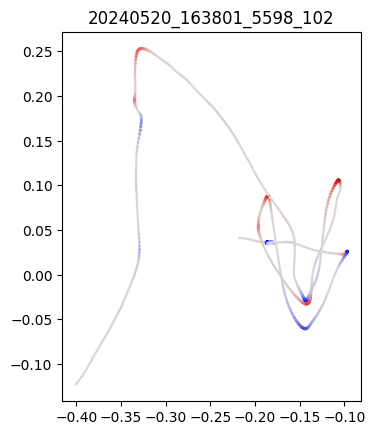

In [14]:
braid_analysis_plots.plot_xy_trajectory_with_color_overlay(trajec, column_for_color='ang_vel_smoother',
                                                           obj_id_key='obj_id')

In [15]:
trajec = flymath.assign_saccade_info_with_modified_gsd(trajec, delta_frames=5)

/home/caveman/PY38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caveman/PY38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/caveman/PY38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caveman/PY38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


array([ 34, 127, 162, 214, 280, 367, 419, 555, 591])

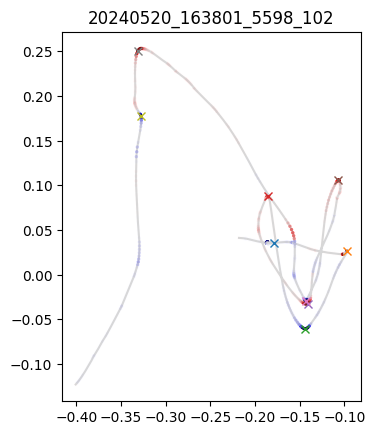

In [17]:
flymath.get_saccade_indices(trajec, height=0.002, distance=20, width=1, plot=True)